# Bandit Comparison: Zoom-In vs GP vs Standard Algorithms

### *Authors:* **Marvin Ernst, Oriol Gelabert, Melisa Vadenja**

Date: May 22, 2025

This notebook compares the performance of different bandit algorithms under a spatial Gaussian reward setting in 2D. We evaluate algorithms using instantaneous and cumulative regret metrics.

**Imports and setup:**

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..")))
from src import (
    generate_ground_truth,
    RegretTracker,
    GaussianUCB, GaussianTS,
    GaussianProcessUCB, GaussianProcessTS,
    get_zoomin_algorithm,
    plot_cumulative_regret, plot_instantaneous_regret, ensure_scalar, plot_arm_positions
)

**Simulation configuration:**

In [20]:
K = 500 
T = 5000
D = 2
SIGMA = 0.01
N_RUNS = 1

algorithms_to_compare = {
    "ZoomIn": lambda f, arms: get_zoomin_algorithm(f, domain=[[0,1],[0,1]], rounds=T)[0],
    "GP-UCB": lambda f, arms: GaussianProcessUCB(arms),
    "GP-TS": lambda f, arms: GaussianProcessTS(arms),
    "UCB":    lambda f, arms: GaussianUCB(K),
    "TS":     lambda f, arms: GaussianTS(K)
}

**Example Bandits Space:**

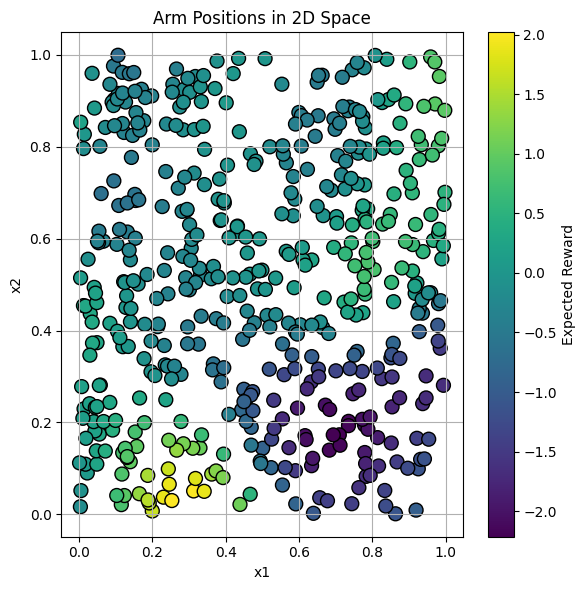

In [21]:
X, mu, f = generate_ground_truth(K=K, d=2, sigma=SIGMA, random_state=42)
plot_arm_positions(X, mu)

**Run simulations:**

In [22]:
records = []

for run in trange(N_RUNS, desc="Simulation runs"):
    X, mu, f = generate_ground_truth(K=K, d=D, sigma=SIGMA, random_state=run)

    for name, constructor in algorithms_to_compare.items():
        algo = constructor(f, X)
        tracker = RegretTracker(mu)

        for t in range(T):
            if name == "ZoomIn":
                x_t = algo.pull(t)
                a_t = np.argmin(np.linalg.norm(X - np.array(x_t), axis=1))
                reward = np.random.normal(f(x_t), SIGMA)
                algo.receive_reward(t, reward)
            else:
                a_t = algo.select_arm()
                reward = np.random.normal(mu[a_t], SIGMA)
                algo.update(a_t, reward)

            tracker.update(a_t)

            records.append({
                'time': t + 1,
                'regret': tracker.get_cumulative_regret(),
                'algorithm': name,
                'run': run
            })

Simulation runs:   0%|          | 0/1 [39:40<?, ?it/s]


KeyboardInterrupt: 

**Convert and group data:**

In [4]:
df = pd.DataFrame(records)
df_avg = df.groupby(['algorithm', 'time']).regret.mean().reset_index()
df_avg.rename(columns={"regret": "avg_regret"}, inplace=True)
df_avg["avg_regret"] = df_avg["avg_regret"].apply(np.ravel).apply(lambda x: x[0] if isinstance(x, (np.ndarray, list)) else x)

**Plot cumulative regret:**

/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset

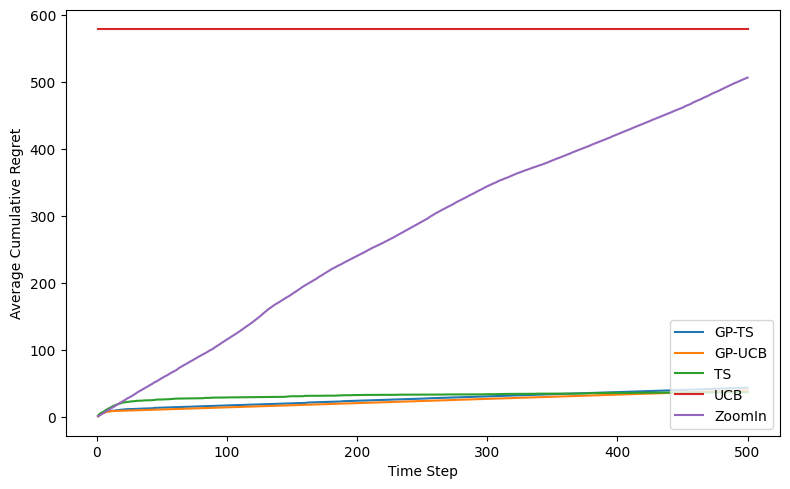

In [5]:
plot_cumulative_regret(df_avg)

**Instantaneous regret plot:**

/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Admin/Library/Caches/pypoetry/virtualenvs/bandits-env-ro35Bmzw-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset

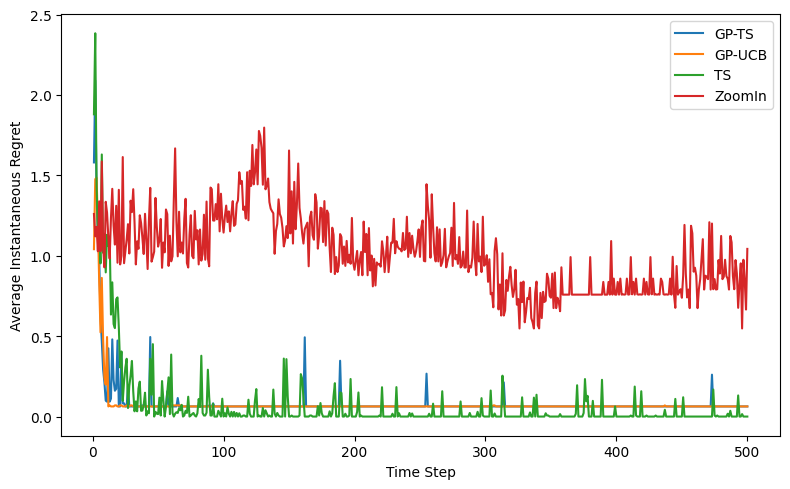

In [ ]:
inst_df = pd.DataFrame(records)
inst_df["regret"] = inst_df.groupby(["run", "algorithm"])['regret'].diff().fillna(inst_df["regret"])

df_inst_avg = inst_df.groupby(['algorithm', 'time'])['regret'].mean().reset_index()
df_inst_avg.rename(columns={"regret": "avg_inst_regret"}, inplace=True)

df_inst_avg["avg_inst_regret"] = df_inst_avg["avg_inst_regret"].apply(ensure_scalar)

df_inst_avg = df_inst_avg.dropna(subset=["avg_inst_regret"])

df_inst_avg["avg_inst_regret"] = df_inst_avg["avg_inst_regret"].astype(float)

plot_instantaneous_regret(df_inst_avg)